<h1>Dogs-vs-Cats</h1>

Using the data from: [dogs-vs-cats] (https://www.kaggle.com/competitions/dogs-vs-cats/)  <br> We should extraxt the zipped folders.

<h2>1-Prepare data<h2>

First import the dependencies. We will talk about each of them later in the program.

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, GlobalAveragePooling2D
import keras_tuner as kt
from PIL import Image
import seaborn as sns

Then lets define where the data is located.

In [2]:
# Define paths
base_dir = 'dogs-vs-cats'
train_dir = os.path.join(base_dir, 'train')

# Display the structure of the dataset
print(f'Training data directory: {train_dir}')

Training data directory: dogs-vs-cats\train


We should check what kind of images we are working.

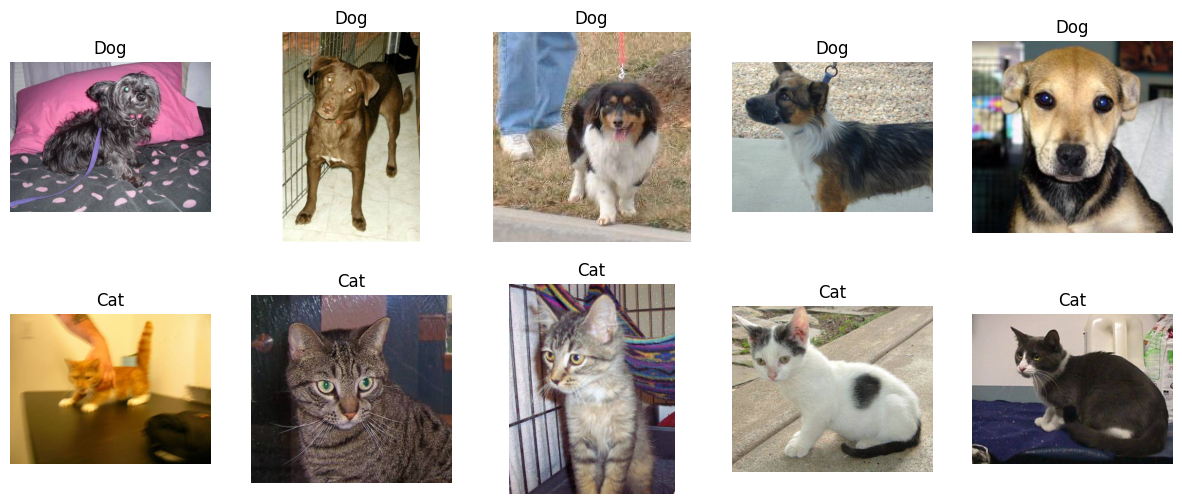

In [3]:
# Example images
example_dogs = [os.path.join(train_dir, 'dog.{}.jpg'.format(i)) for i in range(5)]
example_cats = [os.path.join(train_dir, 'cat.{}.jpg'.format(i)) for i in range(5)]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, img_path in enumerate(example_dogs + example_cats):
    if os.path.exists(img_path):
        img = plt.imread(img_path)
        axes[i // 5, i % 5].imshow(img)
        axes[i // 5, i % 5].axis('off')
        filename = os.path.basename(img_path)
        title = 'Dog' if 'dog' in filename else 'Cat'
        axes[i // 5, i % 5].set_title(title)
    else:
        axes[i // 5, i % 5].text(0.5, 0.5, 'Missing', ha='center', va='center')
        axes[i // 5, i % 5].axis('off')
plt.show()

We will build a dataframe with pandas.

In [4]:
# Create a list of file paths
file_paths = [os.path.join(train_dir, f) for f in os.listdir(train_dir)]

# Create a list of corresponding labels based on file names
labels = ['dog' if 'dog' in f else 'cat' for f in os.listdir(train_dir)]

# Create a DataFrame with file paths and labels
df = pd.DataFrame({
    'file_path': file_paths,
    'label': labels
})

# Display the DataFrame

#Cats
print(df.head())

#Dogs
print(df.tail())

                         file_path label
0     dogs-vs-cats\train\cat.0.jpg   cat
1     dogs-vs-cats\train\cat.1.jpg   cat
2    dogs-vs-cats\train\cat.10.jpg   cat
3   dogs-vs-cats\train\cat.100.jpg   cat
4  dogs-vs-cats\train\cat.1000.jpg   cat
                             file_path label
24995  dogs-vs-cats\train\dog.9995.jpg   dog
24996  dogs-vs-cats\train\dog.9996.jpg   dog
24997  dogs-vs-cats\train\dog.9997.jpg   dog
24998  dogs-vs-cats\train\dog.9998.jpg   dog
24999  dogs-vs-cats\train\dog.9999.jpg   dog


Lets check the numbers by class.

In [5]:
# Count the number of images per class
class_counts = df['label'].value_counts()
print("Number of images per class:")
print(class_counts)

Number of images per class:
label
cat    12500
dog    12500
Name: count, dtype: int64


The images can be any size so lets find an optimal input for the images. We don't want too large width and height, because we can't scale up information. Thats why we will extend our dataframe for some data analysis.

In [6]:
# Get image sizes
def get_image_size(file_path):
    with Image.open(file_path) as img:
        return img.size

df['size'] = df['file_path'].apply(get_image_size)
df[['width', 'height']] = pd.DataFrame(df['size'].tolist(), index=df.index)
df['resolution'] = df['width'] * df['height']

We will be using plotting from matplotlib and with the help from sns. Lets look the distributions.

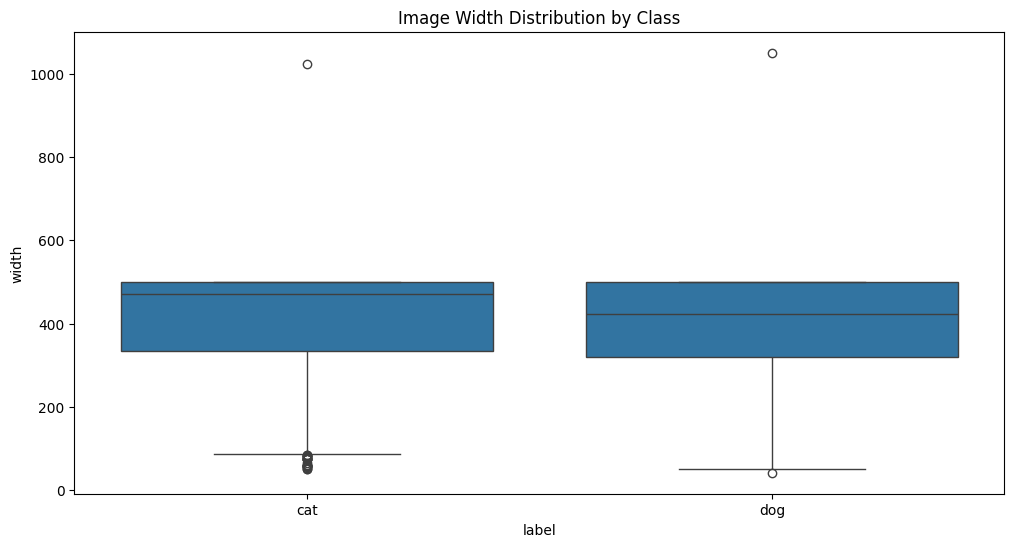

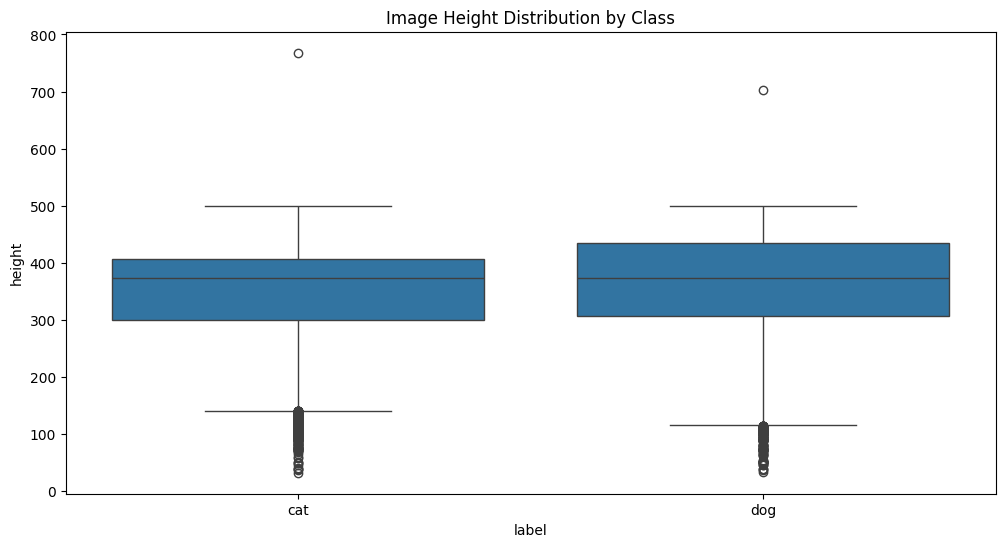

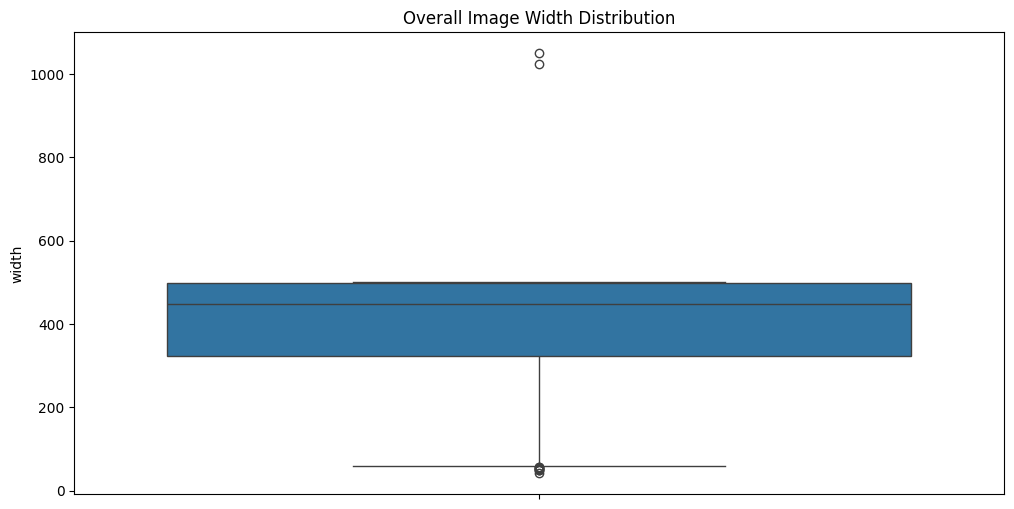

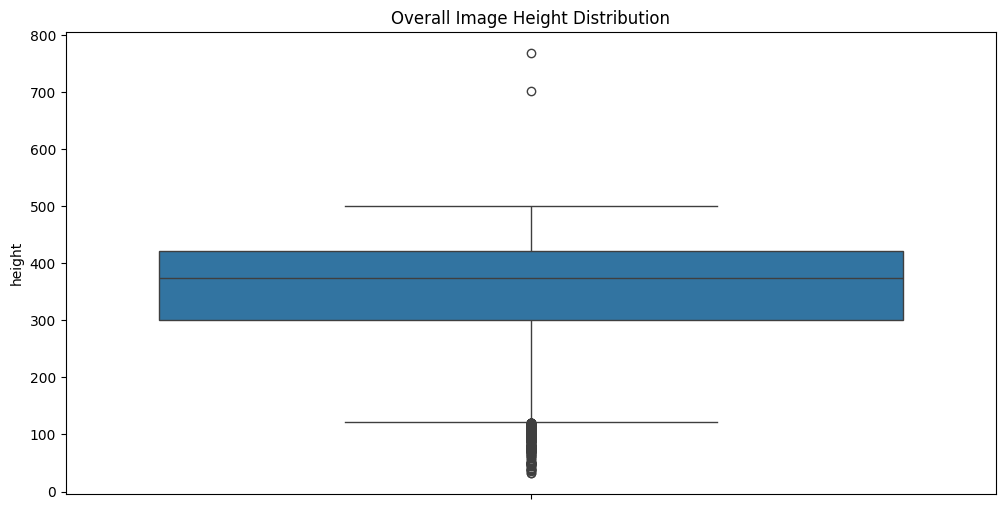

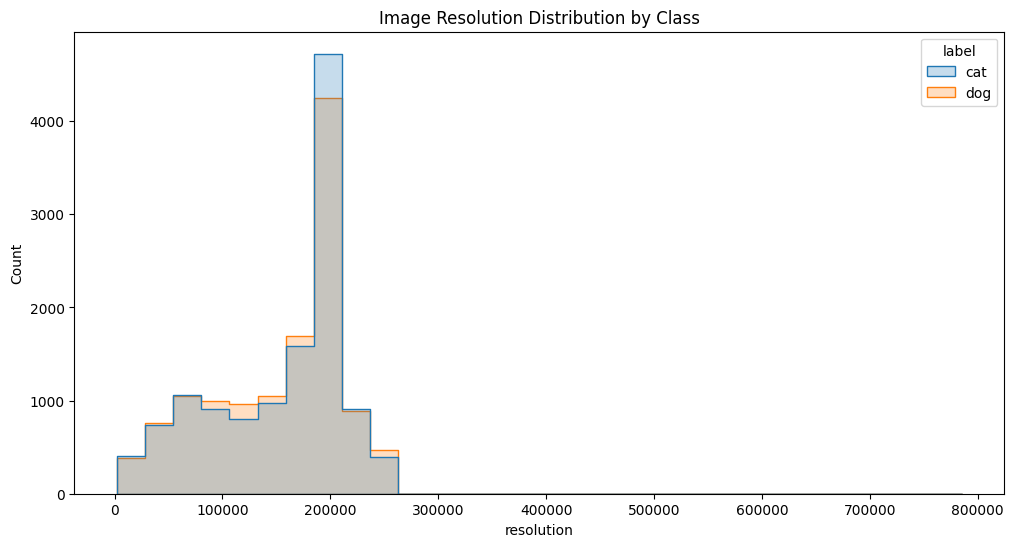

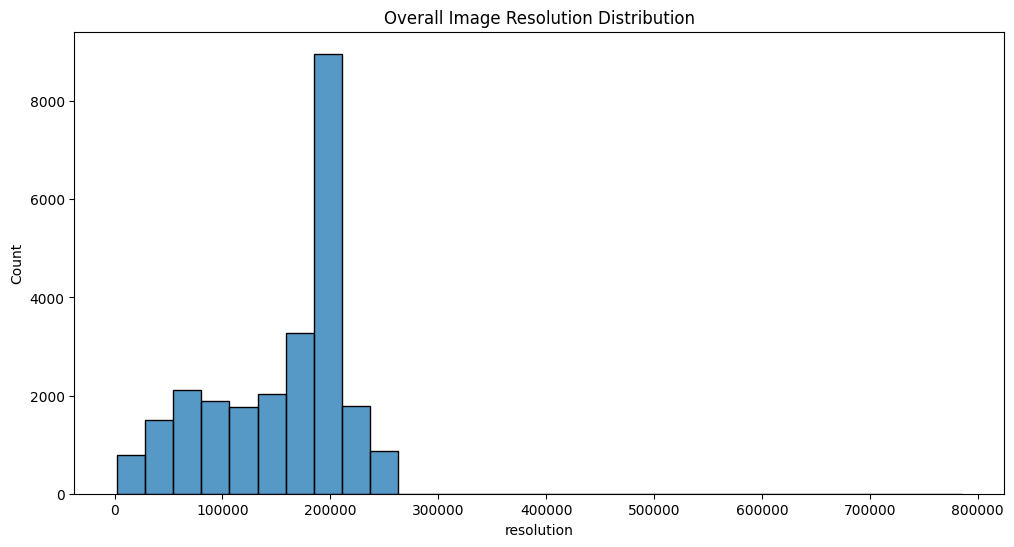

In [7]:
# Plot the distribution of image sizes
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='width', data=df)
plt.title('Image Width Distribution by Class')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='height', data=df)
plt.title('Image Height Distribution by Class')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(y='width', data=df)
plt.title('Overall Image Width Distribution')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(y='height', data=df)
plt.title('Overall Image Height Distribution')
plt.show()

# Plot the distribution of image resolution
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='resolution', hue='label', element='step', bins=30)
plt.title('Image Resolution Distribution by Class')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='resolution', bins=30)
plt.title('Overall Image Resolution Distribution')
plt.show()

As we can see the minimum value for the width and heigth is around 150/150. We won't calculate the outliners. From the plots we can also see that the distributions by the class is very similar, which means we don't have to further alter the data for optimal learning.

For the learning process we will be only using the partial dataset. It is important that the sample number by class should be the same or at least very close.

In [8]:
n_samples_per_class = 2048

dogs_df = df[df['label'] == 'dog'].sample(n=n_samples_per_class, random_state=42)
cats_df = df[df['label'] == 'cat'].sample(n=n_samples_per_class, random_state=42)

sample_df = pd.concat([dogs_df, cats_df]).reset_index(drop=True)

# Count the number of images per class
class_counts = sample_df['label'].value_counts()
print("Number of images per class:")
print(class_counts)

Number of images per class:
label
dog    2048
cat    2048
Name: count, dtype: int64


Lets repeat the data anyalisis for the samples too.

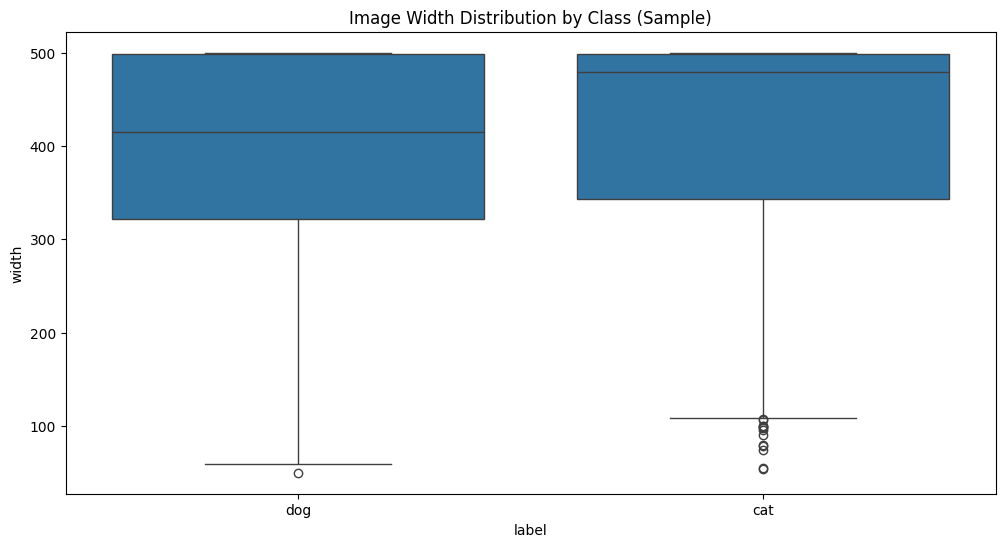

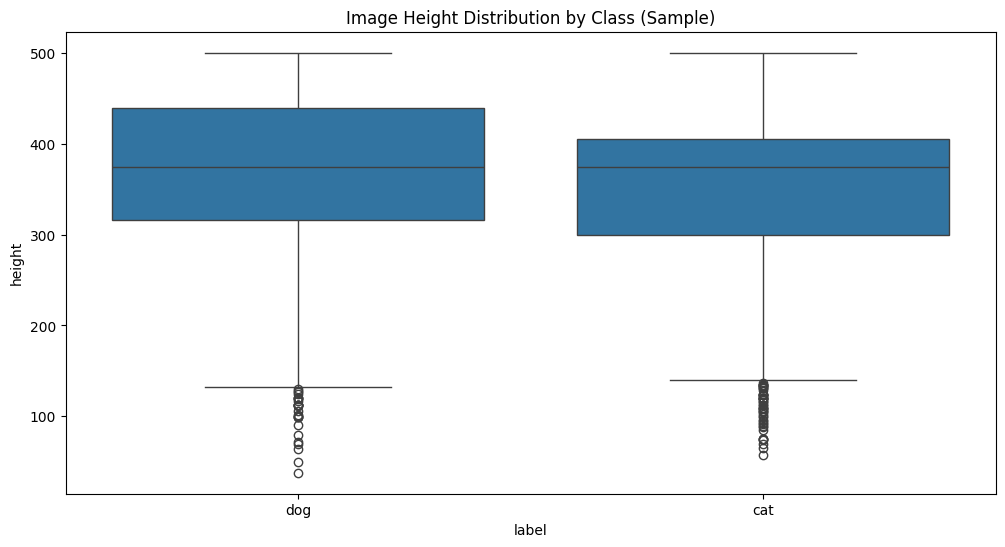

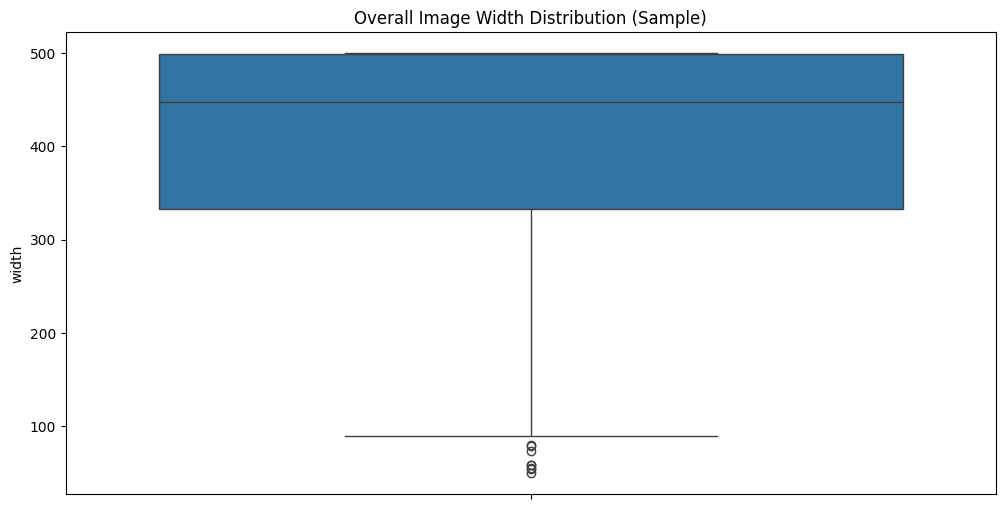

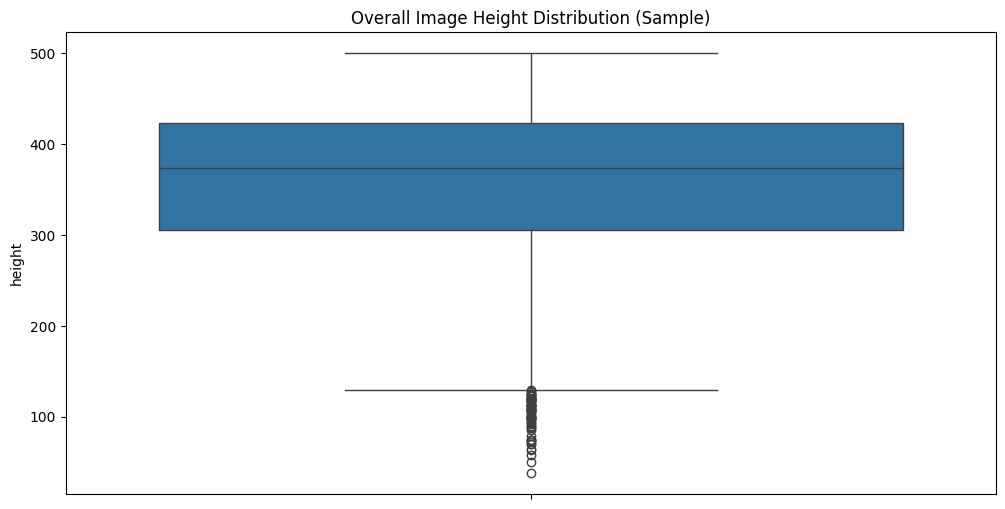

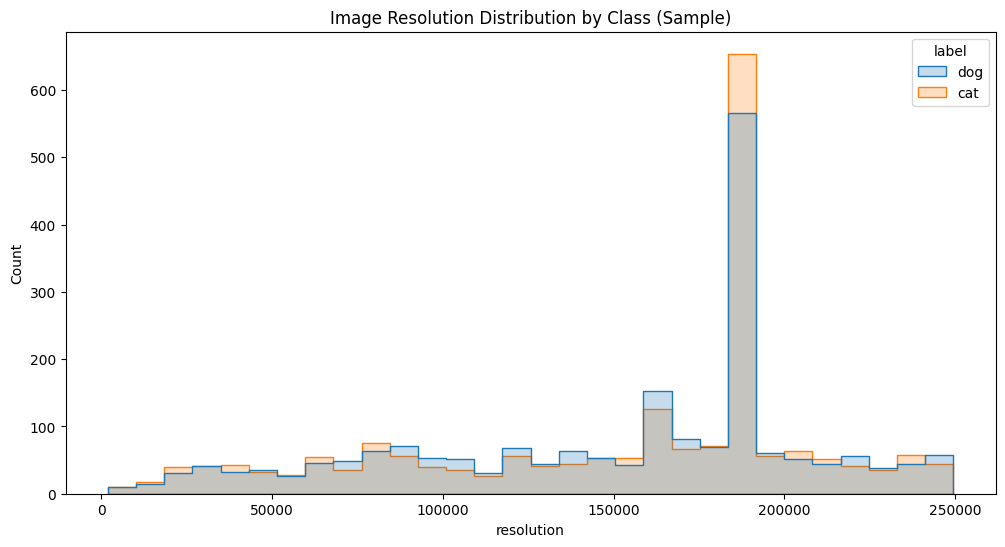

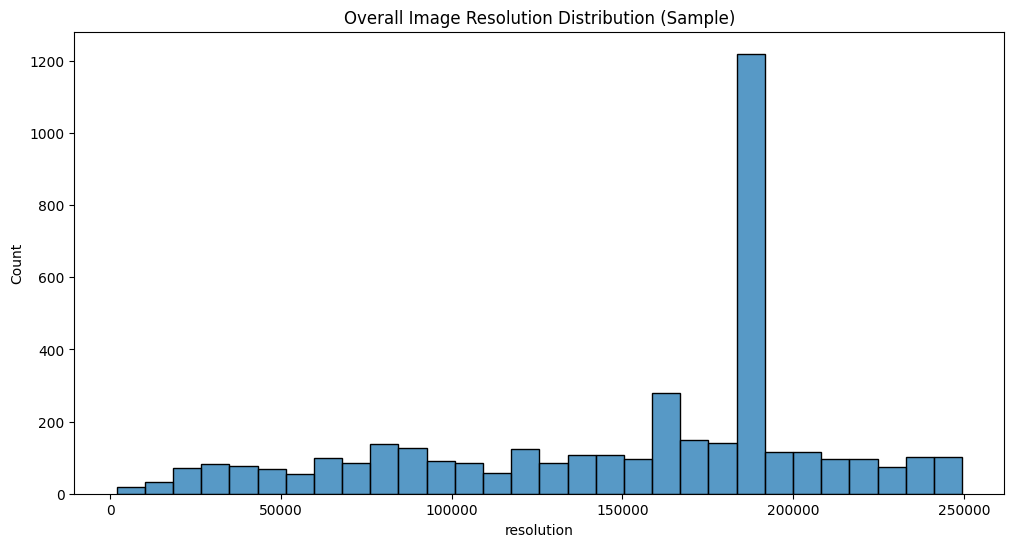

In [9]:
# Plot the distribution of image sizes
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='width', data=sample_df)
plt.title('Image Width Distribution by Class (Sample)')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='height', data=sample_df)
plt.title('Image Height Distribution by Class (Sample)')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(y='width', data=sample_df)
plt.title('Overall Image Width Distribution (Sample)')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(y='height', data=sample_df)
plt.title('Overall Image Height Distribution (Sample)')
plt.show()

# Plot the distribution of image resolution
plt.figure(figsize=(12, 6))
sns.histplot(data=sample_df, x='resolution', hue='label', element='step', bins=30)
plt.title('Image Resolution Distribution by Class (Sample)')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=sample_df, x='resolution', bins=30)
plt.title('Overall Image Resolution Distribution (Sample)')
plt.show()

Looks like that the distributions are similar here.

We should use shuffleing, because in the validation split we get the validation data from the end of the dataframe.

In [10]:
#shuffle the dateset
sample_df = sample_df.sample(frac=1)

print(sample_df.head())
print(sample_df.tail())

                             file_path label        size  width  height  \
1319  dogs-vs-cats\train\dog.12413.jpg   dog  (500, 346)    500     346   
3890   dogs-vs-cats\train\cat.9338.jpg   cat  (499, 290)    499     290   
3297   dogs-vs-cats\train\cat.6420.jpg   cat  (276, 372)    276     372   
2112    dogs-vs-cats\train\cat.401.jpg   cat  (500, 331)    500     331   
2754   dogs-vs-cats\train\cat.9317.jpg   cat  (500, 329)    500     329   

      resolution  
1319      173000  
3890      144710  
3297      102672  
2112      165500  
2754      164500  
                            file_path label        size  width  height  \
3483  dogs-vs-cats\train\cat.4536.jpg   cat  (499, 375)    499     375   
2547  dogs-vs-cats\train\cat.2481.jpg   cat  (364, 399)    364     399   
3235  dogs-vs-cats\train\cat.4908.jpg   cat  (375, 315)    375     315   
883   dogs-vs-cats\train\dog.3486.jpg   dog  (452, 500)    452     500   
164    dogs-vs-cats\train\dog.562.jpg   dog  (399, 390)    399   

We sould use Image data generator, witch helps in case in small sample size, from the images it will create distorted versions.

In [11]:
# Define a data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=sample_df,
    x_col='file_path',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=sample_df,
    x_col='file_path',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 3277 validated image filenames belonging to 2 classes.
Found 819 validated image filenames belonging to 2 classes.


In [12]:
# Define output signature
output_signature = (
    tf.TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(None,), dtype=tf.float32)
)

# Convert the generator to a tf.data.Dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=output_signature
).repeat()

validation_dataset = tf.data.Dataset.from_generator(
    lambda: validation_generator,
    output_signature=output_signature
)

<h2> 2 - model and training <h2>

For the images we will be using Convolutional Neural Network, because the convolutional layers can easyly extract features from spatial domain compared to the classic neural networks.

In [13]:
# Build a simple CNN model
def build_baseline_model(hp=None):
    if hp is None:
        dropout_rate = 0.0
        units = 128
    else:
        dropout_rate = hp.Float('dropout_rate', 0.1, 0.5, step=0.2, default=0.1)
        units = hp.Int('units', min_value=128, max_value=256, step=128, default=128)
    
    model = Sequential([
        Input(shape=(150, 150, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

baseline_model = build_baseline_model()
baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 148, 148, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 72, 72, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      10,616,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,636,865 (40.58 MB)

 Trainable params: 10,636,673 (40.58 MB)

 Non-trainable params: 192 (768.00 B)

We should define some callback functions for the training process. <ul> <li>The Earlystopping will halt the learning process if there is no improvement</li> <li>The ModelCheckpoint will save the weights for the best model in case of overlearning.</li> <li>The ReduceLrLoss will be acting as annealing</li></ul>

In [14]:
# Define the callback to stop early if no improvement is seen
stop_early = EarlyStopping(monitor='val_loss',
    mode='min',
    restore_best_weights=True,
    patience=3)


file_names = ['model_baseline_weights.keras', 'model_1_weights.keras', 'model_2_weights.keras']

mpc_save = [
    ModelCheckpoint(file_name, save_best_only=True, monitor='val_loss', mode='min')
    for file_name in file_names
]


reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, epsilon=1e-4, mode='min')

In [15]:
# Train the model
history = baseline_model.fit(train_dataset,
                             steps_per_epoch=train_generator.samples // train_generator.batch_size,
                             epochs=10,
                             validation_data=validation_dataset,
                             validation_steps=validation_generator.samples // validation_generator.batch_size,
                             callbacks=[stop_early, mpc_save[0], reduce_lr_loss])

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 67s 630ms/step - accuracy: 0.5558 - loss: 4.2795 - val_accuracy: 0.4988 - val_loss: 3.3723 - learning_rate: 0.0010
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 61s 599ms/step - accuracy: 0.6064 - loss: 0.6436 - val_accuracy: 0.4841 - val_loss: 13.0960 - learning_rate: 0.0010
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.6170 - loss: 0.6656
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
102/102 ━━━━━━━━━━━━━━━━━━━━ 62s 607ms/step - accuracy: 0.6170 - loss: 0.6657 - val_accuracy: 0.4867 - val_loss: 5.5432 - learning_rate: 0.0010
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 64s 626ms/step - accuracy: 0.5979 - loss: 0.6556 - val_accuracy: 0.4727 - val_loss: 6.4201 - learning_rate: 1.0000e-04


The model is not so good with the task. It did not learn the proper features of the data.

Lets see how to improve the model by hyperparameter optimaziation.

In [16]:
tuner = kt.Hyperband(
    build_baseline_model,
    objective='val_accuracy',
    max_epochs=5,  
    factor=3,
    directory='hp_dir',
    project_name='bm',
    overwrite=True
)

# Run the hyperparameter search
tuner.search(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size,)

Trial 8 Complete [00h 06m 03s]
val_accuracy: 0.5819568037986755

Best val_accuracy So Far: 0.5819568037986755
Total elapsed time: 00h 26m 43s


In [17]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models()[0]
print(f"""
The optimal dropout rate is {best_hps.get('dropout_rate')} and the optimal unit is {best_hps.get('units')}
""")


The optimal dropout rate is 0.30000000000000004 and the optimal unit is 128



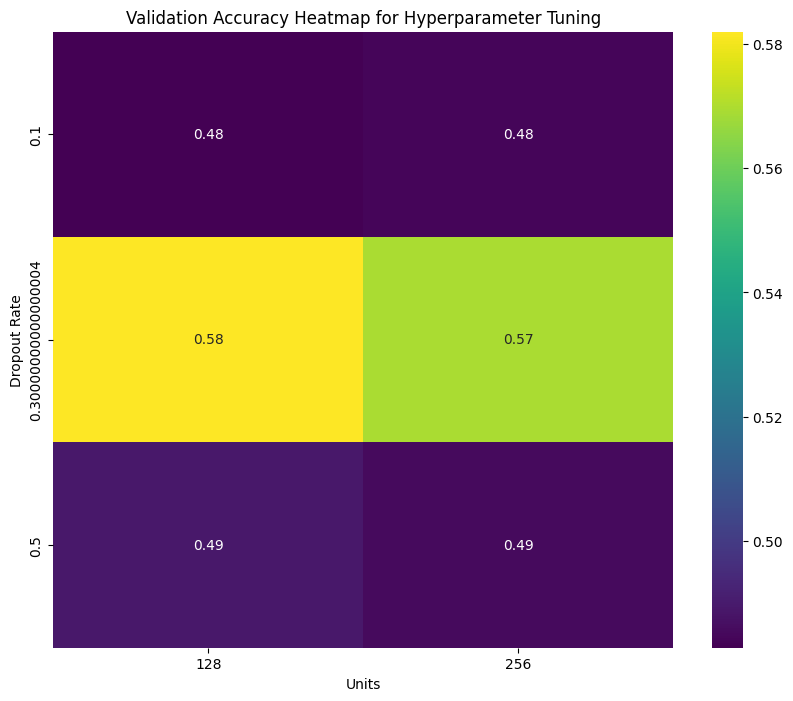

In [18]:
# Collect the results of the search
results = tuner.oracle.get_best_trials(num_trials=10)

# Extract the hyperparameters and their corresponding accuracy
dropout_rates = []
units = []
val_accuracies = []

for trial in results:
    hp_values = trial.hyperparameters.values
    dropout_rates.append(hp_values['dropout_rate'])
    units.append(hp_values['units'])
    val_accuracies.append(trial.score)

import pandas as pd
data = pd.DataFrame({
    'Dropout Rate': dropout_rates,
    'Units': units,
    'Validation Accuracy': val_accuracies
})

# Pivot the DataFrame to create a matrix for the heatmap
pivot_table = data.pivot_table(index='Dropout Rate', columns='Units', values='Validation Accuracy')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap='viridis')
plt.title('Validation Accuracy Heatmap for Hyperparameter Tuning')
plt.show()

Looks like the higher dropout rate around 0.3 is better<br> For the neuron layer there is something not correct, maybe our model is too small.

Lets create a better model, with a plus layer for feature extraction. And with a high dropout rate.

In [19]:
def build_model_v1():
    model = Sequential([
        Input(shape=(150, 150, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(5, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_v1 = build_model_v1()
model_v1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,035,073 (72.61 MB)

 Trainable params: 19,034,625 (72.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [20]:
history_v1 = model_v1.fit(train_dataset,
                          steps_per_epoch=train_generator.samples // train_generator.batch_size,
                          epochs=10,
                          validation_data=validation_dataset,
                          validation_steps=validation_generator.samples // validation_generator.batch_size,
                          callbacks=[stop_early, mpc_save[1], reduce_lr_loss])

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 88s 839ms/step - accuracy: 0.5683 - loss: 4.2067 - val_accuracy: 0.5070 - val_loss: 7.1649 - learning_rate: 0.0010
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 80s 780ms/step - accuracy: 0.5958 - loss: 0.6675 - val_accuracy: 0.4638 - val_loss: 6.7016 - learning_rate: 0.0010
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 79s 779ms/step - accuracy: 0.6289 - loss: 0.6251 - val_accuracy: 0.5235 - val_loss: 1.1719 - learning_rate: 0.0010
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 74s 729ms/step - accuracy: 0.6478 - loss: 0.8461 - val_accuracy: 0.5413 - val_loss: 2.7646 - learning_rate: 0.0010
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 77s 752ms/step - accuracy: 0.5848 - loss: 0.7872 - val_accuracy: 0.6188 - val_loss: 0.6805 - learning_rate: 0.0010
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 74s 725ms/step - accuracy: 0.6455 - loss: 0.6410 - val_accuracy: 0.6264 - val_loss: 0.6225 - learning_rate: 0.0010
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 72s 709ms/step - accuracy: 0.6

If we found the feature extraction lacking lets improve it with an already trained model, which helps us with that. 

In [21]:
def build_model_v2():

    # Load the VGG16 model with pre-trained ImageNet weights, excluding the top layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    
    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_v2 = build_model_v2()
model_v2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         262,6

 Total params: 14,977,857 (57.14 MB)

 Trainable params: 263,169 (1.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [22]:
history_v2 = model_v2.fit(train_dataset,
                          steps_per_epoch=train_generator.samples // train_generator.batch_size,
                          epochs=10,
                          validation_data=validation_dataset,
                          validation_steps=validation_generator.samples // validation_generator.batch_size,
                          callbacks=[stop_early, mpc_save[2], reduce_lr_loss])

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.7168 - loss: 0.5455 - val_accuracy: 0.7929 - val_loss: 0.4338 - learning_rate: 0.0010
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.8040 - loss: 0.4073 - val_accuracy: 0.8450 - val_loss: 0.3381 - learning_rate: 0.0010
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.8175 - loss: 0.3929 - val_accuracy: 0.8399 - val_loss: 0.3613 - learning_rate: 0.0010
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.8475 - loss: 0.3384 - val_accuracy: 0.8513 - val_loss: 0.3249 - learning_rate: 0.0010
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.8451 - loss: 0.3569 - val_accuracy: 0.8666 - val_loss: 0.3144 - learning_rate: 0.0010
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.8540 - loss: 0.3371 - val_accuracy: 0.8501 - val_loss: 0.3220 - learning_rate: 0.0010
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.8388 - loss: 0.

Looks like the final model is better than the previous.

<h2> 3 - Conclusions <h2>

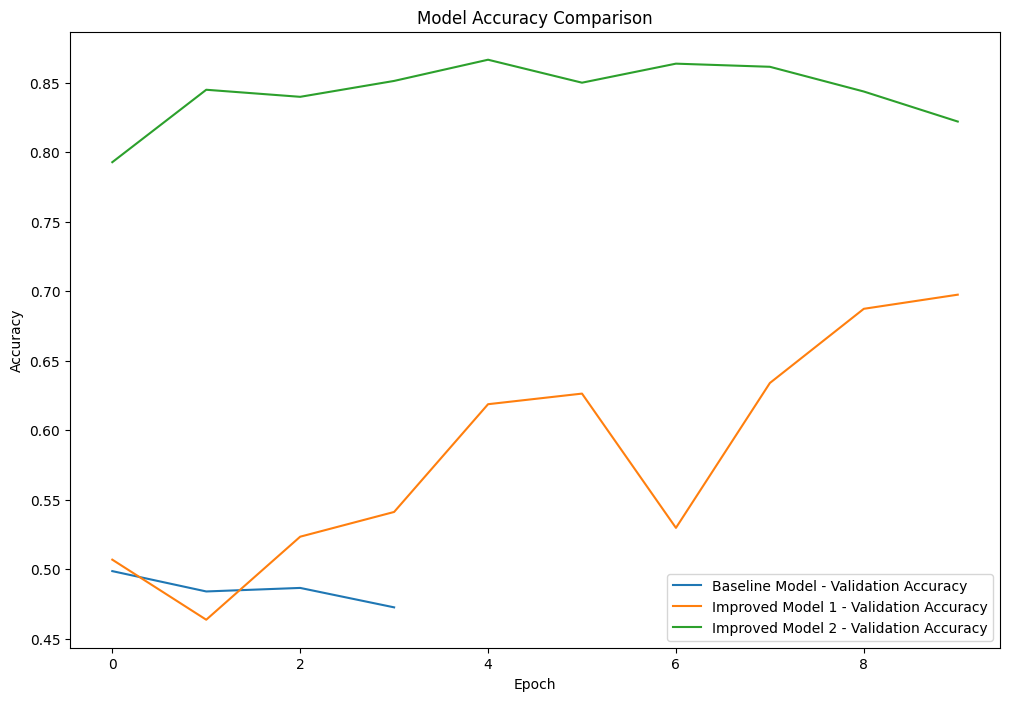

In [23]:
# Function to plot the histories
def plot_histories(histories, titles):
    plt.figure(figsize=(12, 8))
    
    for i, history in enumerate(histories):
        plt.plot(history.history['val_accuracy'], label=f'{titles[i]} - Validation Accuracy')
    
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

# Collect all histories and titles
histories = [history, history_v1, history_v2]
titles = ['Baseline Model', 'Improved Model 1', 'Improved Model 2']

# Plot all histories
plot_histories(histories, titles)

Looks like we need a robust convolutional layer for the task. The improved models reach the optimal accuracy fast, but our first model is stagnant. <br> The improved model 1 could take on more epochs for learning, but the improved model 2 quickly reached the plateau.